In [3]:
from bs4 import BeautifulSoup
# import pandas as pd
from datetime import datetime, timedelta
from itertools import combinations
import json
import requests
import math
from typing import Optional, List, Dict
import os

from pydantic import BaseModel
from typing import Mapping
import numpy as np
import polars as pl
import hvplot.polars
import pandas as pd
import altair as alt
import math

from shared.utils import formalize_data_with_str
from shared.random_rules import RandomRules

In [4]:
rr = RandomRules(
  TOTAL_NUMBERS = 50,
  CHOOSE = 6,
  MAX_PRIMES = 3,
  N_VALUES=["1", "2", "3"],
  # Rangos de valores de las bolillas
  MIN_B_VALUES = [1, 2, 3, 4, 5, 6],
  MAX_B_VALUES = [45, 46, 47, 48, 49, 50]
)

In [5]:
url = 'https://resultados.latinka.com.pe/i.do?m=historico&t=0&s=41'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.select('table')
rows = tables[1].find_all('tr')

In [6]:
lst = []
post_str_b1 = None
post_str_b2 = None
post_str_b3 = None
post_str_b4 = None
post_str_b5 = None
post_str_blast = None
for row in rows:
  cols = [data.text.strip() for data in row.find_all('td')]
  
  id, bolillas_int, str_combo = formalize_data_with_str(bolillas_str=cols[2])
  cols.append(id)
  cols.append(bolillas_int)
  cols.extend([b for b in bolillas_int])
  cols.extend(str_combo)
  cols.append(post_str_b1)
  cols.append(post_str_b2)
  cols.append(post_str_b3)
  cols.append(post_str_b4)
  cols.append(post_str_b5)
  cols.append(post_str_blast)

  is_rare, reason = rr.is_rare_combination(bolillas_int, id)
  cols.append(is_rare)
  cols.append(reason)

  cols.append(rr.jumps_map(bolillas_int))
  cols.append(rr.unijump(bolillas_int))
  
  lst.append(cols)

  post_str_b1 = str_combo[0]
  post_str_b2 = str_combo[1]
  post_str_b3 = str_combo[2]
  post_str_b4 = str_combo[3]
  post_str_b5 = str_combo[4]
  post_str_blast = str_combo[-1]

with open('./gn_tnk_v3.json', 'w') as file: 
  json.dump(lst, file)

dfRows = pl.DataFrame(
  lst,
  schema=[
    'fecha', 'sorteo', 'bolillas', 'yapa', 'adicionales', 'sorteo_extra',
    'id', 'combo', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
    'str_b1', 'str_b2', 'str_b3', 'str_b4', 'str_b5', 'str_b6',
    'post_str_b1', 'post_str_b2', 'post_str_b3', 'post_str_b4', 'post_str_b5', 'post_str_blast',
    'is_rare_combination', 'reason',
    "jumps_map", "unijump"
  ],
  schema_overrides={
    'combo': pl.Array(pl.UInt8, 6),
    'b1': pl.UInt8,
    'b2': pl.UInt8,
    'b3': pl.UInt8,
    'b4': pl.UInt8,
    'b5': pl.UInt8,
    'b6': pl.UInt8,
    'reason': pl.UInt8
  },
  orient='row'
)

TOTAL_LINES = len(dfRows)
print(f'{TOTAL_LINES=}')
display(dfRows.head(10))
dfRows.write_parquet('dfrows_tnk.parquet')

TOTAL_LINES=2489


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""29/06/2025""","""1207""","""47 37 32 22 24 23""","""04""","""20 39 09""","""Promoción Sí o Sí""","""222324323747""","[22, 23, … 47]",22,23,24,32,37,47,"""22""","""23""","""24""","""32""","""37""","""47""",null,null,null,null,null,null,true,24,"""01_01_08_05_10""",35
"""25/06/2025""","""1206""","""38 30 08 27 48 14""","""17""","""18""","""Promoción Sí o Sí""","""081427303848""","[8, 14, … 48]",8,14,27,30,38,48,"""08""","""14""","""27""","""30""","""38""","""48""","""22""","""23""","""24""","""32""","""37""","""47""",false,0,"""06_13_03_08_10""",-50
"""22/06/2025""","""1205""","""07 45 25 33 02 46""","""22""","""27 44""","""Promoción Sí o Sí""","""020725334546""","[2, 7, … 46]",2,7,25,33,45,46,"""02""","""07""","""25""","""33""","""45""","""46""","""08""","""14""","""27""","""30""","""38""","""48""",true,16,"""05_18_08_12_01""",-66
"""18/06/2025""","""1204""","""26 45 28 09 24 50""","""14""","""07""","""Promoción Sí o Sí""","""092426284550""","[9, 24, … 50]",9,24,26,28,45,50,"""09""","""24""","""26""","""28""","""45""","""50""","""02""","""07""","""25""","""33""","""45""","""46""",true,24,"""15_02_02_17_05""",-44
"""15/06/2025""","""1203""","""41 24 42 34 29 44""","""26""","""08 30 39""","""Promoción Sí o Sí""","""242934414244""","[24, 29, … 44]",24,29,34,41,42,44,"""24""","""29""","""34""","""41""","""42""","""44""","""09""","""24""","""26""","""28""","""45""","""50""",true,8,"""05_05_07_01_02""",25
"""11/06/2025""","""1202""","""22 39 20 19 38 15""","""32""","""13 35 25""","""Promoción Sí o Sí""","""151920223839""","[15, 19, … 39]",15,19,20,22,38,39,"""15""","""19""","""20""","""22""","""38""","""39""","""24""","""29""","""34""","""41""","""42""","""44""",false,0,"""04_01_02_16_01""",-51
"""08/06/2025""","""1201""","""05 08 25 18 34 12""","""14""","""44""","""Promoción Sí o Sí""","""050812182534""","[5, 8, … 34]",5,8,12,18,25,34,"""05""","""08""","""12""","""18""","""25""","""34""","""15""","""19""","""20""","""22""","""38""","""39""",false,0,"""03_04_06_07_09""",4
"""04/06/2025""","""1200""","""01 36 50 30 05 21""","""37""","""09 24 43""","""Promoción Sí o Sí""","""010521303650""","[1, 5, … 50]",1,5,21,30,36,50,"""01""","""05""","""21""","""30""","""36""","""50""","""05""","""08""","""12""","""18""","""25""","""34""",false,0,"""04_16_09_06_14""",-16
"""01/06/2025""","""1199""","""02 16 19 14 43 22""","""04""","""17 48 27""","""Promoción Sí o Sí""","""021416192243""","[2, 14, … 43]",2,14,16,19,22,43,"""02""","""14""","""16""","""19""","""22""","""43""","""01""","""05""","""21""","""30""","""36""","""50""",true,8,"""12_02_03_03_21""",31


In [7]:
dfRows.item(0, 'b2')

23

In [8]:
import holoviews as hv
def plot_post_col (col: str, post_col: str, test_value: str | None = None):
  if test_value == None:
    test_value = dfRows.item(0, col)
    print(f'Setting {test_value=}')

  df_viz = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      post_col
    ).agg(pl.count(post_col).alias('count')) \
    .sort("count", descending=True)
  
  
  df_10_last = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .head(10)
  
  # Agrega una columna que sea el porcentaje de la frecuencia relativa
  total = df_viz['count'].sum()
  df_viz = df_viz.with_columns(
    ( (pl.col('count') / total) * 100 ).alias('percent')
  )

  mean_percent = df_viz['percent'].mean()
  mean_percent_75 = mean_percent * 75 / 50
  mean_percent_25 = mean_percent * 25 / 50

  chart = df_viz.hvplot.bar(
    x=post_col,
    y='percent'
  )

  chart = chart * hv.HLine(mean_percent).opts(color='red')
  chart = chart * hv.HLine(mean_percent_75).opts(color='blue')
  chart = chart * hv.HLine(mean_percent_25).opts(color='blue')
  
  chart.opts(default_tools=["pan"])

  df_jumps_map = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      'jumps_map'
    ).agg(pl.count('jumps_map').alias('count')) \
    .sort("count", descending=True)
  
  df_unijump = dfRows \
    .filter(
      pl.col(col) == test_value,
      pl.col(post_col).is_not_null()
    ) \
    .group_by(
      'unijump'
    ).agg(pl.count('unijump').alias('count')) \
    .sort("count", descending=True)


  print(f'df_viz FOR {col} = {test_value}')
  display(df_viz)

  display(chart)
  

  print(f'df_10_last FOR {col} = {test_value}')
  last_results = list(set(df_10_last[post_col][0:3]))
  print(f'Last 3 results {last_results=}')
  display(df_10_last)
  
  print(f'df_jumps_map FOR {col} = {test_value}')
  display(df_jumps_map)
  # display(df_unijump)

  print(f'df_unijump FOR {col} = {test_value}')
  display(df_unijump)

  lst_post_str_b = df_viz.filter(pl.col('percent') >= mean_percent)[post_col].to_list()
  lst_jumps_map = df_jumps_map['jumps_map'].to_list() # Used to discard
  
  return lst_post_str_b, lst_jumps_map, last_results

In [9]:
possible_b1, exclude_jump_maps_b1, last_post_b1 = plot_post_col(col='str_b1', post_col='post_str_b1')

Setting test_value='22'
df_viz FOR str_b1 = 22


post_str_b1,count,percent
str,u32,f64
"""02""",2,18.181818
"""03""",2,18.181818
"""12""",2,18.181818
"""04""",1,9.090909
"""14""",1,9.090909
"""08""",1,9.090909
"""07""",1,9.090909
"""09""",1,9.090909


:Overlay
   .Bars.I    :Bars   [post_str_b1]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b1 = 22
Last 3 results last_results=['12', '02', '09']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""13/04/2025""","""1185""","""22 36 39 48 46 44""","""28""","""09 40""","""Promoción Sí o Sí""","""223639444648""","[22, 36, … 48]",22,36,39,44,46,48,"""22""","""36""","""39""","""44""","""46""","""48""","""12""","""14""","""31""","""38""","""46""","""48""",true,24,"""14_03_05_02_02""",26
"""07/06/2023""","""0992""","""22 27 26 42 30 38""","""40""","""34 13 37""","""Promoción Sí o Sí""","""222627303842""","[22, 26, … 42]",22,26,27,30,38,42,"""22""","""26""","""27""","""30""","""38""","""42""","""02""","""08""","""12""","""20""","""26""","""35""",true,16,"""04_01_03_08_04""",-10
"""05/02/2023""","""0957""","""30 23 37 26 22 39""","""21""","""29 27""","""Promoción Sí o Sí""","""222326303739""","[22, 23, … 39]",22,23,26,30,37,39,"""22""","""23""","""26""","""30""","""37""","""39""","""09""","""14""","""16""","""27""","""31""","""45""",true,16,"""01_03_04_07_02""",-13
"""13/03/2022""","""0863""","""31 43 44 29 33 22""","""16""","""23 39 32""","""Promoción Sí o Sí""","""222931334344""","[22, 29, … 44]",22,29,31,33,43,44,"""22""","""29""","""31""","""33""","""43""","""44""","""02""","""06""","""08""","""24""","""26""","""39""",true,8,"""07_02_02_10_01""",-28
"""09/05/2021""","""0775""","""43 26 22 44 27 29""","""04""","""""","""""","""222627294344""","[22, 26, … 44]",22,26,27,29,43,44,"""22""","""26""","""27""","""29""","""43""","""44""","""12""","""13""","""14""","""15""","""31""","""42""",true,16,"""04_01_02_14_01""",-43
"""26/06/2019""","""0613""","""35 28 22 25 40 34""","""15""","""""","""""","""222528343540""","[22, 25, … 40]",22,25,28,34,35,40,"""22""","""25""","""28""","""34""","""35""","""40""","""07""","""08""","""12""","""19""","""26""","""42""",true,24,"""03_03_06_01_05""",28
"""14/02/2018""","""0471""","""39 44 26 38 22 43""","""27""","""""","""""","""222638394344""","[22, 26, … 44]",22,26,38,39,43,44,"""22""","""26""","""38""","""39""","""43""","""44""","""04""","""11""","""18""","""21""","""27""","""45""",true,16,"""04_12_01_04_01""",-53
"""27/09/2017""","""0431""","""35 24 45 29 22 31""","""41""","""""","""""","""222429313545""","[22, 24, … 45]",22,24,29,31,35,45,"""22""","""24""","""29""","""31""","""35""","""45""","""14""","""17""","""19""","""30""","""33""","""35""",false,0,"""02_05_02_04_10""",-12
"""21/05/2006""","""0711""","""22 35 40 30 43 29""","""16""","""""","""""","""222930354043""","[22, 29, … 43]",22,29,30,35,40,43,"""22""","""29""","""30""","""35""","""40""","""43""","""03""","""07""","""18""","""37""","""40""","""41""",true,24,"""07_01_05_05_03""",16


df_jumps_map FOR str_b1 = 22


jumps_map,count
str,u32
"""14_03_05_02_02""",1
"""07_02_02_10_01""",1
"""04_01_02_14_01""",1
"""04_12_01_04_01""",1
"""03_08_05_04_02""",1
…,…
"""10_01_01_02_05""",1
"""07_01_05_05_03""",1
"""01_03_04_07_02""",1


df_unijump FOR str_b1 = 22


unijump,count
i64,u32
-13,2
-12,1
-43,1
-10,1
16,1
-53,1
26,1
28,1
-28,1


In [10]:
possible_b2, exclude_jump_maps_b2, last_post_b2 = plot_post_col(col='str_b2', post_col='post_str_b2')

Setting test_value='23'
df_viz FOR str_b2 = 23


post_str_b2,count,percent
str,u32,f64
"""12""",7,11.666667
"""08""",6,10.0
"""14""",5,8.333333
"""11""",4,6.666667
"""09""",4,6.666667
…,…,…
"""21""",1,1.666667
"""25""",1,1.666667
"""06""",1,1.666667


:Overlay
   .Bars.I    :Bars   [post_str_b2]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b2 = 23
Last 3 results last_results=['08', '11']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""12/02/2025""","""1168""","""23 18 32 33 24 44""","""48""","""02 27 07""","""Promoción Sí o Sí""","""182324323344""","[18, 23, … 44]",18,23,24,32,33,44,"""18""","""23""","""24""","""32""","""33""","""44""","""06""","""11""","""16""","""22""","""34""","""45""",false,0,"""05_01_08_01_11""",56
"""24/07/2024""","""1110""","""23 32 28 19 38 25""","""40""","""03""","""Promoción Sí o Sí""","""192325283238""","[19, 23, … 38]",19,23,25,28,32,38,"""19""","""23""","""25""","""28""","""32""","""38""","""03""","""08""","""14""","""19""","""25""","""26""",false,0,"""04_02_03_04_06""",4
"""18/02/2024""","""1065""","""42 24 31 12 35 23""","""28""","""37 14 33 07""","""Promoción Sí o Sí""","""122324313542""","[12, 23, … 42]",12,23,24,31,35,42,"""12""","""23""","""24""","""31""","""35""","""42""","""02""","""08""","""14""","""30""","""35""","""39""",false,0,"""11_01_07_04_07""",40
"""09/08/2023""","""1010""","""32 42 23 02 24 27""","""25""","""45 34 09""","""Promoción Sí o Sí""","""022324273242""","[2, 23, … 42]",2,23,24,27,32,42,"""02""","""23""","""24""","""27""","""32""","""42""","""12""","""19""","""25""","""37""","""38""","""42""",true,16,"""21_01_03_05_10""",25
"""05/02/2023""","""0957""","""30 23 37 26 22 39""","""21""","""29 27""","""Promoción Sí o Sí""","""222326303739""","[22, 23, … 39]",22,23,26,30,37,39,"""22""","""23""","""26""","""30""","""37""","""39""","""09""","""14""","""16""","""27""","""31""","""45""",true,16,"""01_03_04_07_02""",-13
"""04/09/2022""","""0913""","""28 23 42 03 37 31""","""21""","""38 45 43 05""","""Promoción Sí o Sí""","""032328313742""","[3, 23, … 42]",3,23,28,31,37,42,"""03""","""23""","""28""","""31""","""37""","""42""","""01""","""02""","""07""","""21""","""32""","""38""",true,1,"""20_05_03_06_05""",-1
"""16/01/2022""","""0847""","""24 23 39 33 44 12""","""05""","""""","""""","""122324333944""","[12, 23, … 44]",12,23,24,33,39,44,"""12""","""23""","""24""","""33""","""39""","""44""","""09""","""18""","""19""","""25""","""32""","""38""",false,0,"""11_01_09_06_05""",42
"""26/12/2021""","""0841""","""29 39 17 36 23 33""","""35""","""38 14 09""","""Promoción Sí o Sí""","""172329333639""","[17, 23, … 39]",17,23,29,33,36,39,"""17""","""23""","""29""","""33""","""36""","""39""","""07""","""08""","""11""","""14""","""17""","""21""",true,8,"""06_06_04_03_03""",-3
"""10/10/2021""","""0819""","""45 20 26 37 23 39""","""08""","""""","""""","""202326373945""","[20, 23, … 45]",20,23,26,37,39,45,"""20""","""23""","""26""","""37""","""39""","""45""","""05""","""22""","""24""","""25""","""29""","""32""",true,24,"""03_03_11_02_06""",55


df_jumps_map FOR str_b2 = 23


jumps_map,count
str,u32
"""11_01_04_09_05""",1
"""08_05_02_04_09""",1
"""04_09_02_02_09""",1
"""20_05_03_06_05""",1
"""17_08_03_05_03""",1
…,…
"""13_01_04_13_04""",1
"""11_01_07_04_07""",1
"""12_10_03_02_06""",1


df_unijump FOR str_b2 = 23


unijump,count
i64,u32
23,3
22,3
1,2
-17,2
-19,2
…,…
16,1
39,1
42,1


In [11]:
possible_b3, exclude_jump_maps_b3, last_post_b3 = plot_post_col(col='str_b3', post_col='post_str_b3')

Setting test_value='24'
df_viz FOR str_b3 = 24


post_str_b3,count,percent
str,u32,f64
"""19""",9,8.571429
"""17""",8,7.619048
"""10""",7,6.666667
"""20""",7,6.666667
"""25""",5,4.761905
…,…,…
"""28""",1,0.952381
"""05""",1,0.952381
"""33""",1,0.952381


:Overlay
   .Bars.I    :Bars   [post_str_b3]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b3 = 24
Last 3 results last_results=['39', '08', '16']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""21/05/2025""","""1196""","""07 36 24 34 45 11""","""01""","""33 47""","""Promoción Sí o Sí""","""071124343645""","[7, 11, … 45]",7,11,24,34,36,45,"""07""","""11""","""24""","""34""","""36""","""45""","""01""","""04""","""08""","""09""","""21""","""31""",false,0,"""04_13_10_02_09""",13
"""09/04/2025""","""1184""","""35 24 49 01 12 39""","""21""","""13 07 26""","""Promoción Sí o Sí""","""011224353949""","[1, 12, … 49]",1,12,24,35,39,49,"""01""","""12""","""24""","""35""","""39""","""49""","""22""","""36""","""39""","""44""","""46""","""48""",false,0,"""11_12_11_04_10""",23
"""12/02/2025""","""1168""","""23 18 32 33 24 44""","""48""","""02 27 07""","""Promoción Sí o Sí""","""182324323344""","[18, 23, … 44]",18,23,24,32,33,44,"""18""","""23""","""24""","""32""","""33""","""44""","""06""","""11""","""16""","""22""","""34""","""45""",false,0,"""05_01_08_01_11""",56
"""05/02/2025""","""1166""","""19 12 27 33 24 30""","""17""","""07""","""Promoción Sí o Sí""","""121924273033""","[12, 19, … 33]",12,19,24,27,30,33,"""12""","""19""","""24""","""27""","""30""","""33""","""03""","""12""","""33""","""34""","""35""","""46""",true,8,"""07_05_03_03_03""",-4
"""01/01/2025""","""1156""","""33 24 09 38 22 46""","""15""","""""","""""","""092224333846""","[9, 22, … 46]",9,22,24,33,38,46,"""09""","""22""","""24""","""33""","""38""","""46""","""13""","""18""","""22""","""35""","""45""","""49""",true,16,"""13_02_09_05_08""",47
"""27/10/2024""","""1137""","""06 27 32 16 24 47""","""42""","""33 34""","""Promoción Sí o Sí""","""061624273247""","[6, 16, … 47]",6,16,24,27,32,47,"""06""","""16""","""24""","""27""","""32""","""47""","""07""","""09""","""15""","""18""","""22""","""42""",false,0,"""10_08_03_05_15""",-9
"""25/09/2024""","""1128""","""39 24 38 50 18 06""","""15""","""23 45 49 44""","""Promoción Sí o Sí""","""061824383950""","[6, 18, … 50]",6,18,24,38,39,50,"""06""","""18""","""24""","""38""","""39""","""50""","""12""","""15""","""26""","""35""","""43""","""47""",false,0,"""12_06_14_01_11""",79
"""24/04/2024""","""1084""","""43 05 24 37 26 04""","""46""","""23 15""","""Promoción Sí o Sí""","""040524263743""","[4, 5, … 43]",4,5,24,26,37,43,"""04""","""05""","""24""","""26""","""37""","""43""","""06""","""22""","""25""","""36""","""41""","""43""",true,16,"""01_19_02_11_06""",-101
"""18/02/2024""","""1065""","""42 24 31 12 35 23""","""28""","""37 14 33 07""","""Promoción Sí o Sí""","""122324313542""","[12, 23, … 42]",12,23,24,31,35,42,"""12""","""23""","""24""","""31""","""35""","""42""","""02""","""08""","""14""","""30""","""35""","""39""",false,0,"""11_01_07_04_07""",40


df_jumps_map FOR str_b3 = 24


jumps_map,count
str,u32
"""10_06_03_05_08""",1
"""08_08_08_05_03""",1
"""10_08_03_05_15""",1
"""09_02_03_04_05""",1
"""06_10_04_04_01""",1
…,…
"""17_06_06_02_05""",1
"""14_09_12_01_03""",1
"""03_10_04_03_07""",1


df_unijump FOR str_b3 = 24


unijump,count
i64,u32
-41,3
-30,3
-9,3
23,3
-4,2
…,…
16,1
79,1
-48,1


In [12]:
possible_b4, exclude_jump_maps_b4, last_post_b4 = plot_post_col(col='str_b4', post_col='post_str_b4')

Setting test_value='32'
df_viz FOR str_b4 = 32


post_str_b4,count,percent
str,u32,f64
"""26""",7,6.930693
"""22""",7,6.930693
"""36""",6,5.940594
"""30""",6,5.940594
"""16""",6,5.940594
…,…,…
"""35""",1,0.990099
"""18""",1,0.990099
"""28""",1,0.990099


:Overlay
   .Bars.I    :Bars   [post_str_b4]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b4 = 32
Last 3 results last_results=['37', '27', '22']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""12/03/2025""","""1176""","""44 34 07 17 16 32""","""11""","""47 40""","""Promoción Sí o Sí""","""071617323444""","[7, 16, … 44]",7,16,17,32,34,44,"""07""","""16""","""17""","""32""","""34""","""44""","""05""","""12""","""15""","""27""","""30""","""49""",false,0,"""09_01_15_02_10""",97
"""12/02/2025""","""1168""","""23 18 32 33 24 44""","""48""","""02 27 07""","""Promoción Sí o Sí""","""182324323344""","[18, 23, … 44]",18,23,24,32,33,44,"""18""","""23""","""24""","""32""","""33""","""44""","""06""","""11""","""16""","""22""","""34""","""45""",false,0,"""05_01_08_01_11""",56
"""18/09/2024""","""1126""","""26 10 34 37 21 32""","""45""","""20 15""","""Promoción Sí o Sí""","""102126323437""","[10, 21, … 37]",10,21,26,32,34,37,"""10""","""21""","""26""","""32""","""34""","""37""","""04""","""17""","""20""","""37""","""38""","""48""",false,0,"""11_05_06_02_03""",22
"""07/08/2024""","""1114""","""10 38 36 18 32 14""","""33""","""31 29 42 28""","""Promoción Sí o Sí""","""101418323638""","[10, 14, … 38]",10,14,18,32,36,38,"""10""","""14""","""18""","""32""","""36""","""38""","""12""","""18""","""38""","""43""","""47""","""50""",true,12,"""04_04_14_04_02""",58
"""10/03/2024""","""1071""","""35 34 18 32 12 30""","""24""","""07 04 19""","""Promoción Sí o Sí""","""121830323435""","[12, 18, … 35]",12,18,30,32,34,35,"""12""","""18""","""30""","""32""","""34""","""35""","""16""","""18""","""34""","""43""","""46""","""48""",true,8,"""06_12_02_02_01""",-37
"""13/12/2023""","""1046""","""10 42 37 02 32 01""","""25""","""16 46 04""","""Promoción Sí o Sí""","""010210323742""","[1, 2, … 42]",1,2,10,32,37,42,"""01""","""02""","""10""","""32""","""37""","""42""","""05""","""10""","""11""","""17""","""22""","""38""",true,8,"""01_08_22_05_05""",86
"""10/12/2023""","""1045""","""06 40 32 17 47 24""","""18""","""07""","""Promoción Sí o Sí""","""061724324047""","[6, 17, … 47]",6,17,24,32,40,47,"""06""","""17""","""24""","""32""","""40""","""47""","""01""","""02""","""10""","""32""","""37""","""42""",true,8,"""11_07_08_08_07""",6
"""12/11/2023""","""1037""","""27 43 17 26 46 32""","""06""","""19 44 01 37""","""Promoción Sí o Sí""","""172627324346""","[17, 26, … 46]",17,26,27,32,43,46,"""17""","""26""","""27""","""32""","""43""","""46""","""08""","""10""","""12""","""15""","""19""","""29""",false,0,"""09_01_05_11_03""",-6
"""23/08/2023""","""1014""","""32 43 38 25 24 11""","""20""","""34 06""","""Promoción Sí o Sí""","""112425323843""","[11, 24, … 43]",11,24,25,32,38,43,"""11""","""24""","""25""","""32""","""38""","""43""","""14""","""16""","""20""","""22""","""28""","""38""",false,0,"""13_01_07_06_05""",32


df_jumps_map FOR str_b4 = 32


jumps_map,count
str,u32
"""12_03_09_03_02""",1
"""07_08_15_06_06""",1
"""07_09_14_01_01""",1
"""09_03_06_04_06""",1
"""06_06_14_04_06""",1
…,…
"""16_04_04_03_10""",1
"""17_04_04_09_01""",1
"""05_07_14_01_03""",1


df_unijump FOR str_b4 = 32


unijump,count
i64,u32
22,4
23,3
-30,2
-32,2
-11,2
…,…
-42,1
-86,1
-26,1


In [13]:
possible_b5, exclude_jump_maps_b5, last_post_b5 = plot_post_col(col='str_b5', post_col='post_str_b5')

Setting test_value='37'
df_viz FOR str_b5 = 37


post_str_b5,count,percent
str,u32,f64
"""41""",12,8.391608
"""37""",11,7.692308
"""40""",9,6.293706
"""42""",8,5.594406
"""36""",8,5.594406
…,…,…
"""12""",1,0.699301
"""14""",1,0.699301
"""16""",1,0.699301


:Overlay
   .Bars.I    :Bars   [post_str_b5]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b5 = 37
Last 3 results last_results=['37', '28', '46']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""26/03/2025""","""1180""","""43 01 05 37 35 13""","""39""","""38 07 45 16""","""Promoción Sí o Sí""","""010513353743""","[1, 5, … 43]",1,5,13,35,37,43,"""01""","""05""","""13""","""35""","""37""","""43""","""25""","""28""","""29""","""31""","""46""","""47""",true,19,"""04_08_22_02_06""",102
"""23/03/2025""","""1179""","""24 07 18 03 37 49""","""43""","""50 28""","""Promoción Sí o Sí""","""030718243749""","[3, 7, … 49]",3,7,18,24,37,49,"""03""","""07""","""18""","""24""","""37""","""49""","""01""","""05""","""13""","""35""","""37""","""43""",false,0,"""04_11_06_13_12""",-44
"""09/10/2024""","""1132""","""15 20 48 37 27 23""","""39""","""07 38 19""","""Promoción Sí o Sí""","""152023273748""","[15, 20, … 48]",15,20,23,27,37,48,"""15""","""20""","""23""","""27""","""37""","""48""","""05""","""09""","""17""","""21""","""28""","""31""",false,0,"""05_03_04_10_11""",-12
"""24/04/2024""","""1084""","""43 05 24 37 26 04""","""46""","""23 15""","""Promoción Sí o Sí""","""040524263743""","[4, 5, … 43]",4,5,24,26,37,43,"""04""","""05""","""24""","""26""","""37""","""43""","""06""","""22""","""25""","""36""","""41""","""43""",true,16,"""01_19_02_11_06""",-101
"""06/03/2024""","""1070""","""30 22 04 07 39 37""","""38""","""43 02 18""","""Promoción Sí o Sí""","""040722303739""","[4, 7, … 39]",4,7,22,30,37,39,"""04""","""07""","""22""","""30""","""37""","""39""","""12""","""18""","""30""","""32""","""34""","""35""",true,16,"""03_15_08_07_02""",-35
"""13/12/2023""","""1046""","""10 42 37 02 32 01""","""25""","""16 46 04""","""Promoción Sí o Sí""","""010210323742""","[1, 2, … 42]",1,2,10,32,37,42,"""01""","""02""","""10""","""32""","""37""","""42""","""05""","""10""","""11""","""17""","""22""","""38""",true,8,"""01_08_22_05_05""",86
"""16/08/2023""","""1012""","""37 19 13 26 45 02""","""32""","""25 33 38""","""Promoción Sí o Sí""","""021319263745""","[2, 13, … 45]",2,13,19,26,37,45,"""02""","""13""","""19""","""26""","""37""","""45""","""06""","""07""","""25""","""27""","""34""","""43""",true,1,"""11_06_07_11_08""",-7
"""05/02/2023""","""0957""","""30 23 37 26 22 39""","""21""","""29 27""","""Promoción Sí o Sí""","""222326303739""","[22, 23, … 39]",22,23,26,30,37,39,"""22""","""23""","""26""","""30""","""37""","""39""","""09""","""14""","""16""","""27""","""31""","""45""",true,16,"""01_03_04_07_02""",-13
"""27/11/2022""","""0937""","""37 36 20 01 11 38""","""35""","""16 39 27""","""Promoción Sí o Sí""","""011120363738""","[1, 11, … 38]",1,11,20,36,37,38,"""01""","""11""","""20""","""36""","""37""","""38""","""01""","""05""","""09""","""17""","""33""","""41""",true,8,"""10_09_16_01_01""",67


df_jumps_map FOR str_b5 = 37


jumps_map,count
str,u32
"""02_17_10_03_02""",1
"""13_03_04_07_03""",1
"""03_03_03_05_06""",1
"""02_01_13_18_03""",1
"""06_05_07_01_07""",1
…,…
"""11_01_04_09_05""",1
"""04_11_06_13_12""",1
"""02_12_15_06_06""",1


df_unijump FOR str_b5 = 37


unijump,count
i64,u32
0,6
-59,4
-41,3
-1,3
-5,3
…,…
31,1
-45,1
115,1


In [14]:
possible_blast, exclude_jump_maps_blast, last_post_blast = plot_post_col(col='str_b6', post_col='post_str_blast')

Setting test_value='47'
df_viz FOR str_b6 = 47


post_str_blast,count,percent
str,u32,f64
"""47""",5,17.857143
"""42""",4,14.285714
"""44""",3,10.714286
"""50""",3,10.714286
"""49""",2,7.142857
…,…,…
"""48""",1,3.571429
"""41""",1,3.571429
"""35""",1,3.571429


:Overlay
   .Bars.I    :Bars   [post_str_blast]   (percent)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

df_10_last FOR str_b6 = 47
Last 3 results last_results=['44', '46']


fecha,sorteo,bolillas,yapa,adicionales,sorteo_extra,id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_b2,post_str_b3,post_str_b4,post_str_b5,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,str,str,str,str,str,str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""30/03/2025""","""1181""","""46 29 25 31 28 47""","""13""","""18 34 23""","""Promoción Sí o Sí""","""252829314647""","[25, 28, … 47]",25,28,29,31,46,47,"""25""","""28""","""29""","""31""","""46""","""47""","""10""","""22""","""23""","""31""","""40""","""46""",false,0,"""03_01_02_15_01""",-48
"""05/03/2025""","""1174""","""01 32 03 12 28 47""","""20""","""49 06 23 24""","""Promoción Sí o Sí""","""010312283247""","[1, 3, … 47]",1,3,12,28,32,47,"""01""","""03""","""12""","""28""","""32""","""47""","""01""","""20""","""23""","""38""","""42""","""44""",false,0,"""02_09_16_04_15""",61
"""19/02/2025""","""1170""","""44 02 19 47 29 31""","""21""","""32 14 35""","""Promoción Sí o Sí""","""021929314447""","[2, 19, … 47]",2,19,29,31,44,47,"""02""","""19""","""29""","""31""","""44""","""47""","""05""","""08""","""10""","""30""","""36""","""44""",true,1,"""17_10_02_13_03""",-60
"""15/01/2025""","""1160""","""36 16 47 38 19 46""","""32""","""18 24 43 08""","""Promoción Sí o Sí""","""161936384647""","[16, 19, … 47]",16,19,36,38,46,47,"""16""","""19""","""36""","""38""","""46""","""47""","""01""","""02""","""05""","""23""","""44""","""45""",true,16,"""03_17_02_08_01""",-84
"""08/01/2025""","""1158""","""40 25 24 47 20 44""","""31""","""46 30 09""","""Promoción Sí o Sí""","""202425404447""","[20, 24, … 47]",20,24,25,40,44,47,"""20""","""24""","""25""","""40""","""44""","""47""","""26""","""32""","""34""","""41""","""44""","""49""",true,16,"""04_01_15_04_03""",77
"""18/12/2024""","""1152""","""22 28 33 19 47 35""","""44""","""13 32""","""Promoción Sí o Sí""","""192228333547""","[19, 22, … 47]",19,22,28,33,35,47,"""19""","""22""","""28""","""33""","""35""","""47""","""01""","""02""","""17""","""24""","""40""","""49""",false,0,"""03_06_05_02_12""",13
"""27/10/2024""","""1137""","""06 27 32 16 24 47""","""42""","""33 34""","""Promoción Sí o Sí""","""061624273247""","[6, 16, … 47]",6,16,24,27,32,47,"""06""","""16""","""24""","""27""","""32""","""47""","""07""","""09""","""15""","""18""","""22""","""42""",false,0,"""10_08_03_05_15""",-9
"""16/10/2024""","""1134""","""29 31 08 47 12 10""","""50""","""41 33""","""Promoción Sí o Sí""","""081012293147""","[8, 10, … 47]",8,10,12,29,31,47,"""08""","""10""","""12""","""29""","""31""","""47""","""08""","""10""","""15""","""24""","""33""","""50""",true,8,"""02_02_17_02_16""",104
"""29/09/2024""","""1129""","""43 47 26 35 15 12""","""45""","""08 04 06""","""Promoción Sí o Sí""","""121526354347""","[12, 15, … 47]",12,15,26,35,43,47,"""12""","""15""","""26""","""35""","""43""","""47""","""13""","""17""","""20""","""43""","""47""","""50""",false,0,"""03_11_09_08_04""",-15


df_jumps_map FOR str_b6 = 47


jumps_map,count
str,u32
"""07_01_13_03_03""",1
"""04_01_15_04_03""",1
"""02_01_28_10_01""",1
"""13_04_21_01_02""",1
"""05_03_07_08_05""",1
…,…
"""15_05_01_13_07""",1
"""02_10_02_22_06""",1
"""03_11_09_08_04""",1


df_unijump FOR str_b6 = 47


unijump,count
i64,u32
104,2
6,2
-44,1
-54,1
1,1
…,…
81,1
-78,1
-84,1


In [15]:
b_count = rr.CHOOSE
min_b = rr.MIN_B_VALUES[0]
max_b = rr.MAX_B_VALUES[-1]


combos = combinations(range(min_b, max_b + 1), b_count)
# print("generating combos: ", len(list(combos)))

In [16]:
parquet_file = './parquet_tnk_v3.parquet'

# check if parquet_file exists
if not os.path.exists(parquet_file):
  print(f'{parquet_file=} does not exists. creating')
  lst = []
  post_str_b1 = None
  post_str_blast = None
  for row in combos:
    cols = []
    str_row = " ".join([str(r).zfill(2) for r in row])
    id, bolillas_int, str_combo = formalize_data_with_str(bolillas_str=str_row)
    cols.append(id)
    cols.append(bolillas_int)
    cols.extend([b for b in bolillas_int])
    cols.extend(str_combo)
    cols.append(post_str_b1)
    cols.append(post_str_blast)

    is_rare, reason = rr.is_rare_combination(bolillas_int, id)
    cols.append(is_rare)
    cols.append(reason)

    cols.append(rr.jumps_map(bolillas_int))
    cols.append(rr.unijump(bolillas_int))
    
    lst.append(cols)

    post_str_b1 = str_combo[0]
    post_str_blast = str_combo[-1]

  df_Orows = pl.DataFrame(
    lst,
    schema=[
      # 'fecha', 'sorteo', 'bolillas',
      'id', 'combo', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
      'str_b1', 'str_b2', 'str_b3', 'str_b4', 'str_b5', 'str_b6',
      'post_str_b1', 'post_str_blast',
      'is_rare_combination', 'reason',
      "jumps_map", "unijump"
    ],
    schema_overrides={
      'combo': pl.Array(pl.UInt8, 6),
      'b1': pl.UInt8,
      'b2': pl.UInt8,
      'b3': pl.UInt8,
      'b4': pl.UInt8,
      'b5': pl.UInt8,
      'b6': pl.UInt8,
      'reason': pl.UInt8
    },
    orient='row'
  )

  df_Orows.write_parquet(parquet_file)
  TOTAL_LINES = len(df_Orows)
  print(f'{TOTAL_LINES=} loaded to {parquet_file=}')

  display(df_Orows.head(10))
else:
  df_Orows = pl.read_parquet(parquet_file)

In [17]:
# possible_b1, exclude_jump_maps_b1
df_possible = df_Orows.filter(
  # pl.col("str_b1").is_in(["10", "11", "12", "13", "14", "15", "16"]),
  pl.col("str_b1").is_in(["03", "04", "06", "07",]),
  # pl.col("str_b1").is_in(possible_b1),
  # pl.col("str_b2").is_in(possible_b2),
  # pl.col("str_b3").is_in(possible_b3),
  # pl.col("str_b4").is_in(possible_b4),
  # pl.col("str_b5").is_in(possible_b5),
  # pl.col("str_b6").is_in(possible_blast),
  
  # ~pl.col("str_b1").is_in(last_post_b1),
  ~pl.col("str_b2").is_in(last_post_b2 + ["40", "41", "42", "43", "44", "45", "46", "47", "48", "49"]),
  ~pl.col("str_b3").is_in(last_post_b3 + ["40", "41", "42", "43", "44", "45", "46", "47", "48", "49"]),
  ~pl.col("str_b4").is_in(last_post_b4 + ["10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25"]),
  ~pl.col("str_b5").is_in(last_post_b5 + ["27"]),
  ~pl.col("str_b6").is_in(last_post_blast + ["20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "45", "46", "47", "48", "49", "50"]),

  ~pl.col("jumps_map").is_in(exclude_jump_maps_b1 + exclude_jump_maps_b2 + exclude_jump_maps_b3 + exclude_jump_maps_b4 + exclude_jump_maps_b5 + exclude_jump_maps_blast),
  # ~pl.col("jumps_map").is_in(exclude_jump_maps_b1 + exclude_jump_maps_b2 + exclude_jump_maps_blast),
  pl.col("is_rare_combination") == False
)


display(df_possible)

id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""030406070912""","[3, 4, … 12]",3,4,6,7,9,12,"""03""","""04""","""06""","""07""","""09""","""12""","""03""","""11""",false,0,"""01_02_01_02_03""",-6
"""030406071012""","[3, 4, … 12]",3,4,6,7,10,12,"""03""","""04""","""06""","""07""","""10""","""12""","""03""","""11""",false,0,"""01_02_01_03_02""",-11
"""030406071042""","[3, 4, … 42]",3,4,6,7,10,42,"""03""","""04""","""06""","""07""","""10""","""42""","""03""","""41""",false,0,"""01_02_01_03_32""",19
"""030406071112""","[3, 4, … 12]",3,4,6,7,11,12,"""03""","""04""","""06""","""07""","""11""","""12""","""03""","""50""",false,0,"""01_02_01_04_01""",-16
"""030406071142""","[3, 4, … 42]",3,4,6,7,11,42,"""03""","""04""","""06""","""07""","""11""","""42""","""03""","""41""",false,0,"""01_02_01_04_31""",14
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""073536384142""","[7, 35, … 42]",7,35,36,38,41,42,"""07""","""35""","""36""","""38""","""41""","""42""","""07""","""50""",false,0,"""28_01_02_03_01""",25
"""073536394142""","[7, 35, … 42]",7,35,36,39,41,42,"""07""","""35""","""36""","""39""","""41""","""42""","""07""","""50""",false,0,"""28_01_03_02_01""",35
"""073537384142""","[7, 35, … 42]",7,35,37,38,41,42,"""07""","""35""","""37""","""38""","""41""","""42""","""07""","""50""",false,0,"""28_02_01_03_01""",15


In [18]:
df_possible.sample(n=1)


id,combo,b1,b2,b3,b4,b5,b6,str_b1,str_b2,str_b3,str_b4,str_b5,str_b6,post_str_b1,post_str_blast,is_rare_combination,reason,jumps_map,unijump
str,"array[u8, 6]",u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str,bool,u8,str,i64
"""030610262936""","[3, 6, … 36]",3,6,10,26,29,36,"""03""","""06""","""10""","""26""","""29""","""36""","""03""","""35""",false,0,"""03_04_16_03_07""",78


# Aplicando Laplace + dist teórica

In [19]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parámetros por casilla
PARAMETROS_CASILLA = {
    "b1": {"rango": (1, 45), "mu": 5, "sigma": 5},
    "b2": {"rango": (2, 46), "mu": 13.5, "sigma": 5},
    "b3": {"rango": (3, 47), "mu": 21, "sigma": 4},
    "b4": {"rango": (4, 48), "mu": 28, "sigma": 4},
    "b5": {"rango": (5, 49), "mu": 35.5, "sigma": 5},
    "b6": {"rango": (6, 50), "mu": 45, "sigma": 5},
}

def calcular_probabilidades_hibridas(casilla, valores, suavizado=1, mezcla=0.5, top_n=5, graficar=False):
    # Obtener parámetros
    param = PARAMETROS_CASILLA[casilla]
    r_min, r_max = param["rango"]
    mu = param["mu"]
    sigma = param["sigma"]
    
    rango = list(range(r_min, r_max + 1))
    total_posibles = len(rango)
    total_observaciones = len(valores)

    # --- Probabilidad teórica (distribución normal)
    dist_normal = norm(loc=mu, scale=sigma)
    p_teorica = {v: dist_normal.pdf(v) for v in rango}

    # Normalizar las probabilidades teóricas
    suma_teorica = sum(p_teorica.values())
    for v in p_teorica:
        p_teorica[v] /= suma_teorica

    # --- Probabilidad empírica con Laplace
    conteo = defaultdict(int)
    for v in valores:
        conteo[v] += 1

    p_laplace = {
        v: (conteo[v] + suavizado) / (total_observaciones + total_posibles * suavizado)
        for v in rango
    }

    # --- Mezcla de ambos modelos
    p_combinada = {
        v: mezcla * p_teorica[v] + (1 - mezcla) * p_laplace[v]
        for v in rango
    }

    # Ordenar resultados
    p_ordenada = dict(sorted(p_combinada.items(), key=lambda x: x[1], reverse=True))

    # Graficar si se desea
    if graficar:
        plt.figure(figsize=(10, 4))
        plt.plot(list(p_teorica.keys()), list(p_teorica.values()), label='Distribución Teórica', linestyle='--', alpha=0.7)
        plt.plot(list(p_laplace.keys()), list(p_laplace.values()), label='Laplace (Empírica)', linestyle=':', alpha=0.7)
        plt.plot(list(p_combinada.keys()), list(p_combinada.values()), label='Combinada', linewidth=2)
        plt.title(f"Probabilidades combinadas para {casilla}")
        plt.xlabel("Valor")
        plt.ylabel("Probabilidad")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Retornar los valores más probables
    return list(p_ordenada.items())[:top_n]


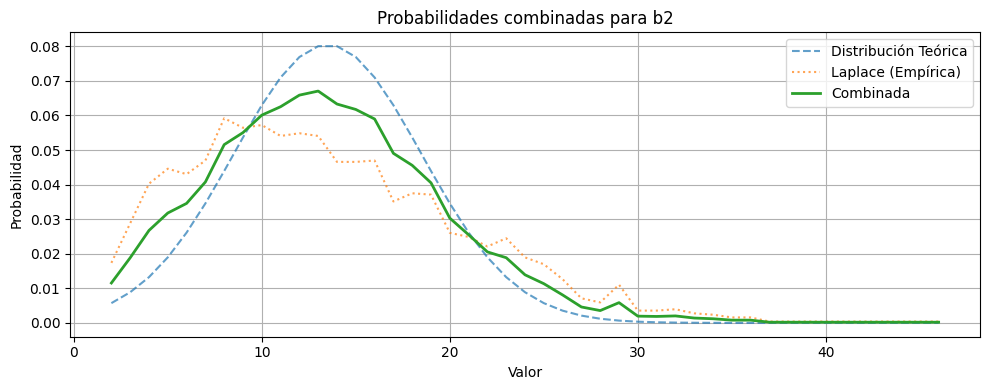

🎯 Siguientes valores más probables para b2:
  13: 0.0671
  12: 0.0659
  14: 0.0633
  11: 0.0625
  15: 0.0617
  10: 0.0601
  16: 0.0590
  9: 0.0550
  8: 0.0516
  17: 0.0490


In [33]:
col_analyze = "b2"
values_explore = dfRows[col_analyze].to_list()
values_explore.reverse()

# valores más probables usando mezcla 50% teórica y 50% datos
top_valores = calcular_probabilidades_hibridas(col_analyze, values_explore, mezcla=0.5, graficar=True, top_n=10)

print(f"🎯 Siguientes valores más probables para {col_analyze}:")
for val, prob in top_valores:
    print(f"  {val}: {prob:.4f}")
